## Importing Required Libraries

In [1]:
# import general packages
import os
import pickle
import sys

import pandas as pd

# Setting up local details:
# This should be the location of the checkout of the THEMAP repository:
repo_path = os.path.dirname(os.path.abspath(""))
CHECKOUT_PATH = repo_path
DATASET_PATH = os.path.join(repo_path, "datasets")
EXT_PROT_PATH = os.path.join(DATASET_PATH, "fsmol_hardness", "ext_prot")
PROTONET_PATH = os.path.join(DATASET_PATH, "fsmol_hardness", "FSMol_Eval_ProtoNet")

os.chdir(CHECKOUT_PATH)
sys.path.insert(0, CHECKOUT_PATH)

In [2]:
# import visualization packages
import matplotlib
import matplotlib.pyplot as plt

from themap.utils import (
    compute_task_hardness_from_distance_matrix,
    normalize,
    protein_hardness_from_distance_matrix,
)

light_color = plt.get_cmap("plasma").colors[170]
dark_color = "black"

# matplotlib.use("pgf")

matplotlib.rcParams.update(
    {
        "pgf.texsystem": "pdflatex",
        "font.family": "serif",
        "font.serif": "Computer Modern Roman",
        "font.size": 20,
        "text.usetex": True,
        "pgf.rcfonts": False,
    }
)

In [3]:
ESM2_t6_8M = os.path.join(EXT_PROT_PATH, "esm2_t6_8M_UR50D.pkl")
ESM2_t12_35M = os.path.join(EXT_PROT_PATH, "esm2_t12_35M_UR50D.pkl")
ESM2_t30_150M = os.path.join(EXT_PROT_PATH, "esm2_t30_150M_UR50D.pkl")
ESM2_t33_650M = os.path.join(EXT_PROT_PATH, "esm2_t33_650M_UR50D.pkl")
ESM2_t36_3B = os.path.join(EXT_PROT_PATH, "esm2_t36_3B_UR50D.pkl")

protonet_16 = os.path.join(PROTONET_PATH, "summary", "ProtoNet_summary_num_train_requested_16.csv")
protonet_32 = os.path.join(PROTONET_PATH, "summary", "ProtoNet_summary_num_train_requested_32.csv")
protonet_64 = os.path.join(PROTONET_PATH, "summary", "ProtoNet_summary_num_train_requested_64.csv")
protonet_128 = os.path.join(PROTONET_PATH, "summary", "ProtoNet_summary_num_train_requested_128.csv")

## Correlation plot between number of k-nearest source tasks and EXT_PROT

correlation between protein hardness and delta_auprc (k=1):  -0.28594593179272143
correlation between protein hardness and roc_auc (k=1):  -0.2672619795387243
correlation between protein hardness and delta_auprc (k=10):  -0.3504880705120862
correlation between protein hardness and roc_auc (k=10):  -0.34482435785725657
correlation between protein hardness and delta_auprc (k=50):  -0.4267807641662723
correlation between protein hardness and roc_auc (k=50):  -0.44220539929058655
correlation between protein hardness and delta_auprc (k=100):  -0.4225808779275135
correlation between protein hardness and roc_auc (k=100):  -0.4386819381384938
correlation between protein hardness and delta_auprc (k=500):  -0.34779565312330024
correlation between protein hardness and roc_auc (k=500):  -0.3576397814153787
correlation between protein hardness and delta_auprc (k=1000):  -0.3033414935957162
correlation between protein hardness and roc_auc (k=1000):  -0.3094985468377913
correlation between protein ha

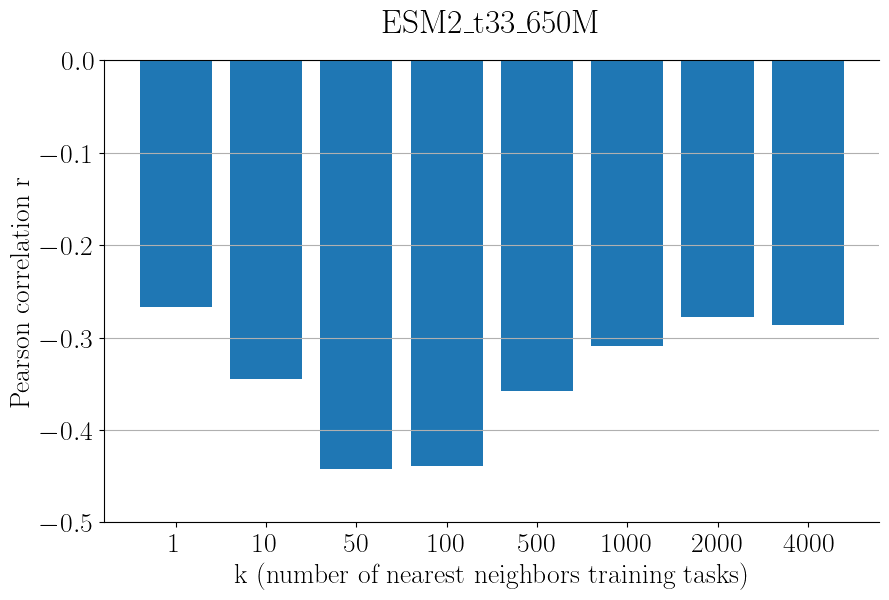

In [7]:
# Choose the ESM2 model to use
ESM2_model = "ESM2_t33_650M"

mapping_model_to_path = {
    "ESM2_t6_8M": ESM2_t6_8M,
    "ESM2_t12_35M": ESM2_t12_35M,
    "ESM2_t30_150M": ESM2_t30_150M,
    "ESM2_t33_650M": ESM2_t33_650M,
    "ESM2_t36_3B": ESM2_t36_3B,
}

with open(mapping_model_to_path[ESM2_model], "rb") as f:
    protein_distance_matrix = pickle.load(f)

corr_ROC = []
corr_AUPRC = []
k_list = [1, 10, 50, 100, 500, 1000, 2000, 4000]
for k in k_list:
    protein_path = mapping_model_to_path[ESM2_model]
    protein_hardness_df = protein_hardness_from_distance_matrix(protein_path, k=k)

    protonet_results = pd.read_csv(protonet_128)
    df = protein_hardness_df.merge(protonet_results[["assay", "delta_auprc", "roc_auc"]], on="assay")
    print(
        f"correlation between protein hardness and delta_auprc (k={k}): ",
        df["protein_hardness_mean"].corr(df["delta_auprc"]),
    )
    corr_AUPRC.append(df["protein_hardness_mean"].corr(df["delta_auprc"]))
    print(
        f"correlation between protein hardness and roc_auc (k={k}): ",
        df["protein_hardness_mean"].corr(df["roc_auc"]),
    )
    corr_ROC.append(df["protein_hardness_mean"].corr(df["roc_auc"]))

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.bar([str(i) for i in k_list], corr_ROC)
# ax.set_title('Correlation between external protein hardness and ROC-AUC', pad=20)
ax.set_title(ESM2_model, pad=20)
ax.set_xlabel("k (number of nearest neighbors training tasks)")
ax.set_ylabel("Pearson correlation r")

ax.set_ylim(-0.5, 0)
ax.grid(axis="y")
ax.spines["right"].set_visible(False)
# ax.text(-0.07, 1.05, 'D', transform=ax.transAxes,
#      fontsize=24, fontweight='bold', va='top', ha='right')
# ax.text(4000, -0.6, 'GIN Supervised Infomax', fontsize=15)
plt.show()

## Correlation between different protein representations (ESM2 models)

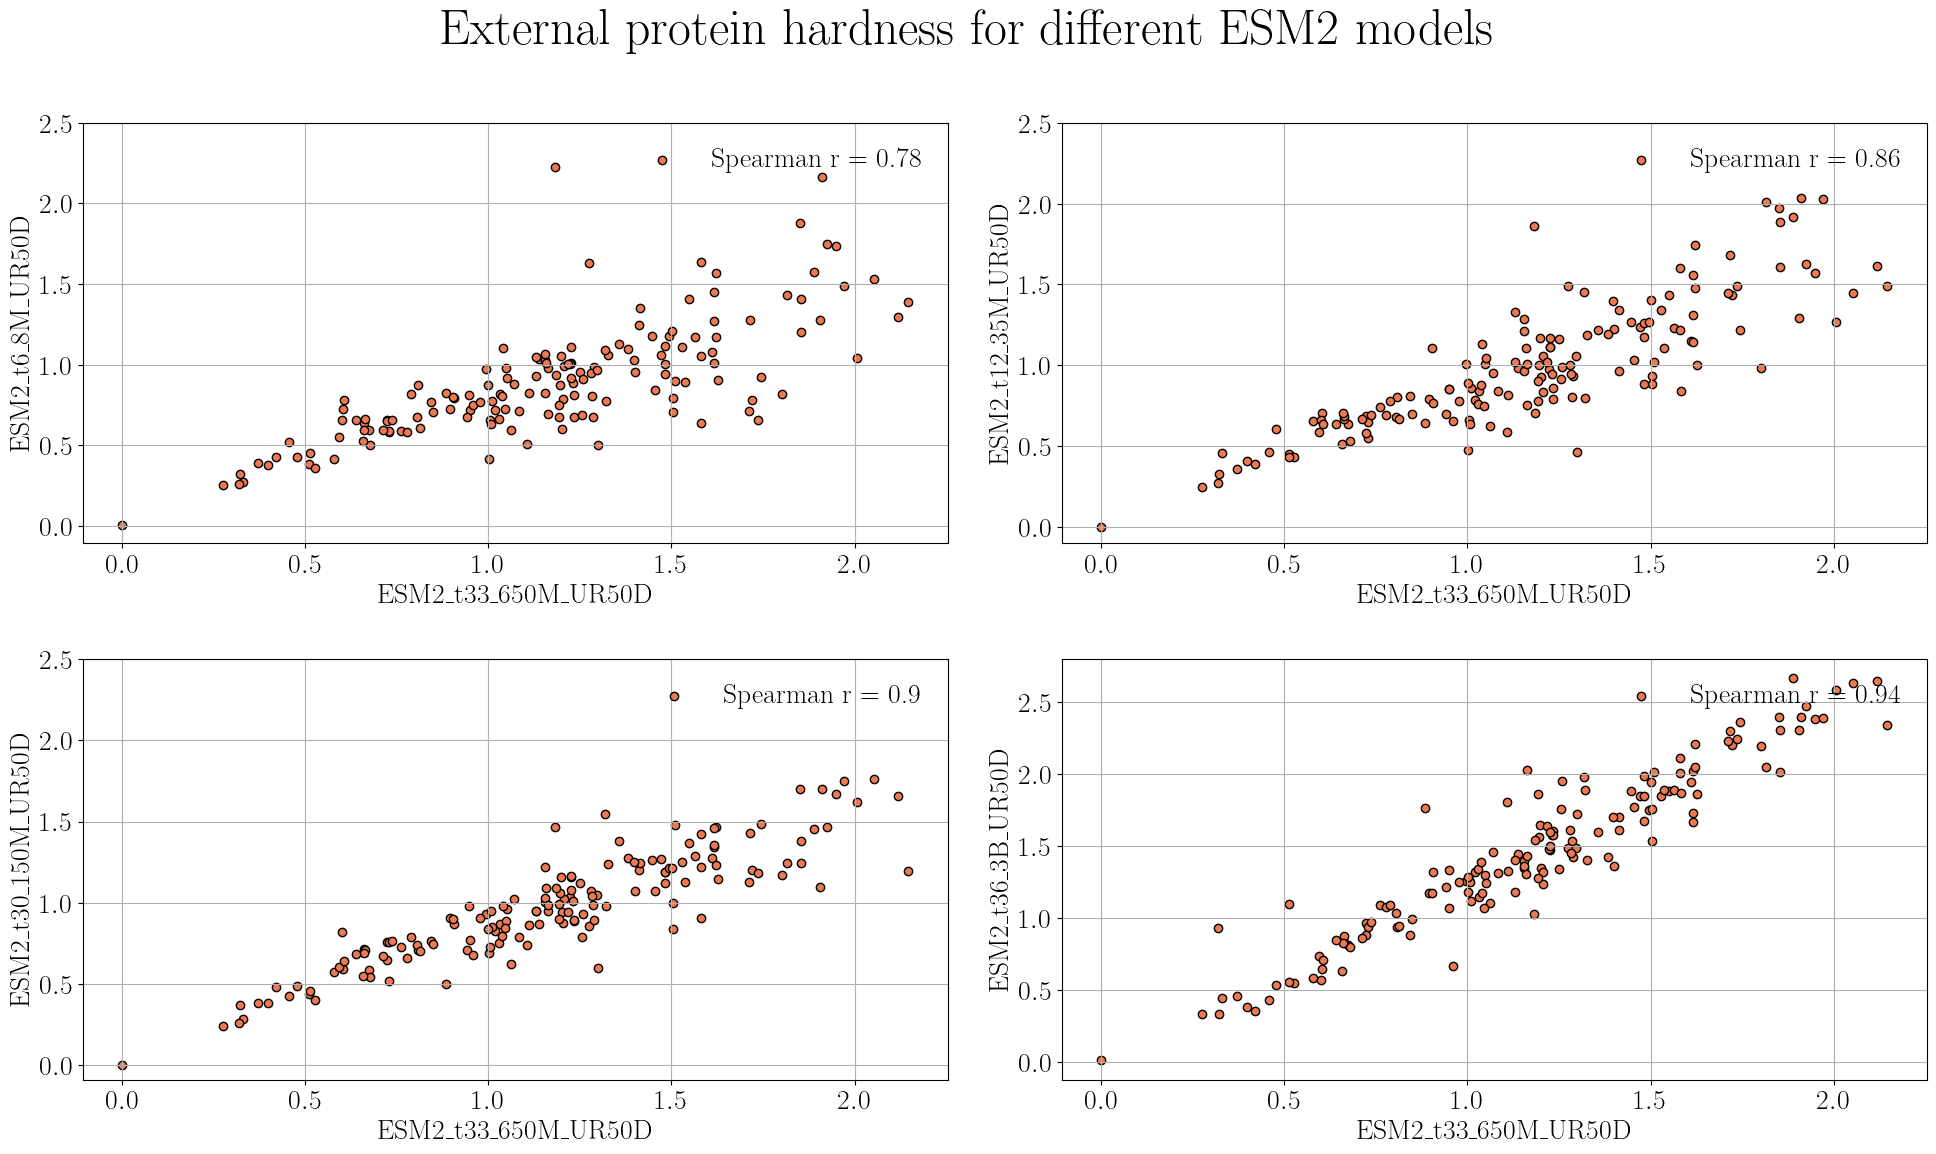

In [8]:
##Comparing different ESM2 methods (for different feature types)
ESM2_models = ["ESM2_t6_8M", "ESM2_t12_35M", "ESM2_t30_150M", "ESM2_t33_650M", "ESM2_t36_3B"]
k = 10
hardness_df_dict = {}
for ESM2_model in ESM2_models:
    with open(mapping_model_to_path[ESM2_model], "rb") as f:
        protein_distance_matrix = pickle.load(f)
    hardness_protien = compute_task_hardness_from_distance_matrix(
        protein_distance_matrix["distance_matrices"], aggr="mean_median", proportion=k
    )
    test_chembl_ids = protein_distance_matrix["test_chembl_ids"]
    hardness_protien_mean_norm = normalize(hardness_protien[0])
    hardness_protien_median_norm = normalize(hardness_protien[1])
    df = pd.DataFrame(
        {
            f"protein_hardness_mean_{ESM2_model}": hardness_protien[0],
            f"protein_hardness_median_{ESM2_model}": hardness_protien[1],
            "assay": test_chembl_ids,
        }
    )
    hardness_df_dict[ESM2_model] = df


hardness_df = pd.merge(
    hardness_df_dict["ESM2_t6_8M"], hardness_df_dict["ESM2_t12_35M"], on="assay", how="outer"
)
hardness_df = pd.merge(hardness_df, hardness_df_dict["ESM2_t30_150M"], on="assay", how="outer")
hardness_df = pd.merge(hardness_df, hardness_df_dict["ESM2_t33_650M"], on="assay", how="outer")
hardness_df = pd.merge(hardness_df, hardness_df_dict["ESM2_t36_3B"], on="assay", how="outer")


fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2, figsize=(20, 12))

fig.suptitle("External protein hardness for different ESM2 models", fontsize=36)

ax0.scatter(
    hardness_df["protein_hardness_mean_ESM2_t33_650M"],
    hardness_df["protein_hardness_mean_ESM2_t6_8M"],
    color=light_color,
    edgecolor=dark_color,
)
ax0.set_xlabel("ESM2_t33_650M_UR50D")
ax0.set_ylabel("ESM2_t6_8M_UR50D")
sp_corr = round(
    hardness_df["protein_hardness_mean_ESM2_t33_650M"].corr(
        hardness_df["protein_hardness_mean_ESM2_t6_8M"], method="spearman"
    ),
    2,
)
ax0.legend(["Spearman r = {}".format(sp_corr)], loc="upper right", fontsize=20, frameon=False)
ax0.grid(True)
ax0.set_yticks([0.0, 0.5, 1.0, 1.5, 2.0, 2.5])


ax1.scatter(
    hardness_df["protein_hardness_mean_ESM2_t33_650M"],
    hardness_df["protein_hardness_mean_ESM2_t12_35M"],
    color=light_color,
    edgecolor=dark_color,
)
ax1.set_xlabel("ESM2_t33_650M_UR50D")
ax1.set_ylabel("ESM2_t12_35M_UR50D")
sp_corr = round(
    hardness_df["protein_hardness_mean_ESM2_t33_650M"].corr(
        hardness_df["protein_hardness_mean_ESM2_t12_35M"], method="spearman"
    ),
    2,
)
ax1.legend(["Spearman r = {}".format(sp_corr)], loc="upper right", fontsize=20, frameon=False)
ax1.grid(True)
ax1.set_yticks([0.0, 0.5, 1.0, 1.5, 2.0, 2.5])


ax2.scatter(
    hardness_df["protein_hardness_mean_ESM2_t33_650M"],
    hardness_df["protein_hardness_mean_ESM2_t30_150M"],
    color=light_color,
    edgecolor=dark_color,
)
ax2.set_xlabel("ESM2_t33_650M_UR50D")
ax2.set_ylabel("ESM2_t30_150M_UR50D")
sp_corr = round(
    hardness_df["protein_hardness_mean_ESM2_t33_650M"].corr(
        hardness_df["protein_hardness_mean_ESM2_t30_150M"], method="spearman"
    ),
    2,
)
ax2.legend(["Spearman r = {}".format(sp_corr)], loc="upper right", fontsize=20, frameon=False)
ax2.grid(True)
ax2.set_yticks([0.0, 0.5, 1.0, 1.5, 2.0, 2.5])


ax3.scatter(
    hardness_df["protein_hardness_mean_ESM2_t33_650M"],
    hardness_df["protein_hardness_mean_ESM2_t36_3B"],
    color=light_color,
    edgecolor=dark_color,
)
ax3.set_xlabel("ESM2_t33_650M_UR50D")
ax3.set_ylabel("ESM2_t36_3B_UR50D")
sp_corr = round(
    hardness_df["protein_hardness_mean_ESM2_t33_650M"].corr(
        hardness_df["protein_hardness_mean_ESM2_t36_3B"], method="spearman"
    ),
    2,
)
ax3.legend(["Spearman r = {}".format(sp_corr)], loc="upper right", fontsize=20, frameon=False)
ax3.grid(True)
ax3.set_yticks([0.0, 0.5, 1.0, 1.5, 2.0, 2.5])

fig.tight_layout(pad=1.5)

plt.show()